In [2]:
from preprocessing_function_TodasCategorias import *
from functions_MARISA import *


In [3]:
%run functions_MARISA.py

In [4]:
import numpy as np

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet, HuberRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFE

from math import ceil

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, root_mean_squared_error

from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

import time

import warnings
warnings.filterwarnings('ignore')




In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.set_index('carID', inplace=True)
df_test.set_index('carID', inplace=True)

In [7]:
random_state = 42

## Pre-Processing

We start by defining the inconsistent values discussed in the EDA as NA:

In [8]:
df_train.loc[df_train['year']>2020, 'year'] = np.nan
df_test.loc[df_test['year']>2020, 'year'] = np.nan

df_train.loc[df_train['mileage']<0, 'mileage'] = np.nan
df_test.loc[df_test['mileage']<0, 'mileage'] = np.nan

df_train.loc[df_train['tax']<0, 'tax'] = np.nan
df_test.loc[df_test['tax']<0,'tax'] = np.nan

df_train.loc[df_train['mpg']<=0, 'mpg'] = np.nan
df_test.loc[df_test['mpg']<=0, 'mpg'] = np.nan

df_train.loc[df_train['paintQuality%']>100, 'paintQuality%'] = np.nan
df_test.loc[df_test['paintQuality%']>100, 'paintQuality%'] = np.nan

df_train.loc[df_train['previousOwners']< 0, 'previousOwners'] = np.nan
df_test.loc[df_test['previousOwners']< 0, 'previousOwners'] = np.nan

df_train.loc[df_train['engineSize']<= 0, 'engineSize'] = np.nan
df_test.loc[df_test['engineSize']<= 0, 'engineSize'] = np.nan

df_train.loc[df_train['mpg'] < 40, 'mpg'] = np.nan
df_train.loc[df_train['engineSize'] < 1, 'engineSize'] = np.nan

df_test.loc[df_test['mpg'] < 40, 'mpg'] = np.nan
df_test.loc[df_test['engineSize'] < 1, 'engineSize'] = np.nan

We proceed to round 'year' and 'previousOwners' to whole numbers using the floor function. Other numerical features are rounded to 2 decimal points.

In [9]:
df_train['year'] = np.floor(df_train['year'])
df_train['previousOwners'] = np.floor(df_train['previousOwners'])

df_test['year'] = np.floor(df_test['year'])
df_test['previousOwners'] = np.floor(df_test['previousOwners'])

for feat in ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']:
    df_train[feat] = df_train[feat].round(2)
    df_test[feat] = df_test[feat].round(2)

We also pre-process the categorical variables in order to have a uniform format for later treatment (inside k-fold CV). We remove leeading and trailing spaces and uppercase all letters.

In [10]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())

In [11]:

y = df_train['price']
X = df_train.drop('price', axis=1)



Notas sobre as classes:

- variáveis criadas na inicialização não acabam em _; as ue são criadas dentro dos métodos acabam em _!
- criando uma var nos métodos, se ela não começar em self. não será reconhecida por toda a classe, será apenas local!
- logo, iniciar com self. para criar novos atributos gerais (assim transform() cconsegue aceder ao atributo criado em fit() por exemplo)
- cuidado com data leakage! :D

### Categorical_Correction Class

In [12]:

class Categorical_Correction(BaseEstimator, TransformerMixin):

    def __init__(self):  # initialize the transformer
        pass             # self it's how Python refers to the transformer within the class.
                         # self.something --> something its an attribute of the transformer.

    def fit(self, X, y=None): # fit is where we learn from the data
        """ Learns parameters from train data to then use in categorical variable correction inside 
        transformer function of this same class."""


        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        ###### -----------------------------------------------------BRAND----------------------------------------------------------------------######

        self.brands_ = X['Brand'].dropna().unique().tolist()

        _, self.mapping_brand_ = create_clusters(X, self.brands_, 'Brand')

        ######---------------------------------------------------TRANSMISSION--------------------------------------------------------------------######

        self.transmission_types_ = X['transmission'].dropna().unique().tolist()

        _, self.mapping_transmission_ = create_clusters(X, self.transmission_types_, 'transmission')


        ######----------------------------------------------------FUEL TYPE--------------------------------------------------------------------######

        self.fuel_types_= X['fuelType'].dropna().unique().tolist()

        _, self.mapping_fueltype_ = create_clusters(X, self.fuel_types_, 'fuelType')


        ######------------------------------------------------------MODELS----------------------------------------------------------------------######

        self.models_= X['model'].dropna().unique().tolist()

        ## Fuzzywuzzy wasn't able to group the same models in the column 'model', so for this case we will use get_close_matches from the difflib library.
        self.clusters_ = similar_models(self.models_)

        # Calculate counts once before the function
        self.model_counts_ = X['model'].value_counts().to_dict()

        # List to store the most frequent model in each cluster which will be considered the correct one
        self.correct_models_ = []

        #   Dictionary to map each model to its correct version
        self.model_mapping_ = {}

        # For loop to go over all the clusters 
        for group in self.clusters_:

            # The best model of each cluster will be the one with the highest count in the train set, it will be added to the correct_models list
            best = max(group, key=lambda x: self.model_counts_.get(x, 0))
            self.correct_models_.append(best)

            # Map all models in the group to the best model
            for model in group:
                self.model_mapping_[model] = best

        return self
    


    def transform(self, X): # transform is where we apply the learned parameters to correct the data

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # BRAND----------------------------------------------------------------------------------------------

        # We first correct the 'W' brands which should be either VW or BMW
        # this correction does not depent on params learned from train data:
        X['Brand'] = X.apply(lambda row: correct_brand_w(X, row['Brand'], row['model']),axis=1)
        # for cars with no model where correct_brand_w doesn't work:
        X.loc[X['Brand'] =='W' ,'Brand'] = 'VW'

        # Remaining typos:
        X['Brand_cleaned'] = X['Brand'].apply(lambda x: correct_categorical(self.mapping_brand_, x))

        # TRANSMISSION---------------------------------------------------------------------------------------
        X['transmission_cleaned'] = X['transmission'].apply(lambda x: correct_categorical(self.mapping_transmission_, x))


        # FUELTYPE -------------------------------------------------------------------------------------------
        X['fuelType_cleaned'] = X['fuelType'].apply(lambda x: correct_categorical(self.mapping_fueltype_, x))


        # MODEL ---------------------------------------------------------------------------------------------
        X['model_cleaned'] = X['model'].apply(lambda x: correct_column_model(self.correct_models_, self.model_mapping_, x, self.clusters_))


        # Finally, we drop the variables with typos:
        X = X.drop(['Brand', 'model', 'transmission', 'fuelType'], axis=1)


        return X



### Outlier_Treatment Class

In [13]:
class Outlier_Treatment(BaseEstimator, TransformerMixin):

    def __init__(self, dim=3, ratio = 0.00008):
        self.feat_lst = ['tax', 'mileage', 'mpg', 'engineSize', 'year', 'paintQuality%', 'previousOwners']
        self.dim = dim
        self.ratio = ratio

    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.outlier_limits_ = {}
        self.quantiles_ = {}

        for feat in self.feat_lst:
            Q1 = X[feat].quantile(0.25)
            Q3 = X[feat].quantile(0.75)
            IQR = Q3 - Q1
            self.outlier_limits_[feat] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
            self.quantiles_[feat] = (X[feat].quantile(0.01),X[feat].quantile(0.99))
            

        return self
    
    def transform(self, X):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        outlier_counts = pd.Series(0, index=X.index)

        for feat in self.feat_lst:

            upper = self.outlier_limits_[feat][1]
            lower = self.outlier_limits_[feat][0]

            # counting in how many feats each point is an outlier 
            #outlier_counts += ((X[feat] < lower) | (X[feat] >  upper)).astype(int)


            if X[X[feat] > upper].shape[0]/ X.shape[0] >= self.ratio:
                X.loc[X[feat] > upper, feat] = self.quantiles_[feat][1]

            if X[X[feat] < lower].shape[0]/ X.shape[0] >= self.ratio:
                X.loc[X[feat] < lower, feat] = self.quantiles_[feat][0]


        return X
    




### Missing_Value_Treatment Class

In [14]:
class Missing_Value_Treatment(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)


        # Missing BRAND ---------------------------------------------------------------------------------
        self.brand_mode_ = X['Brand_cleaned'].mode().iloc[0]
        self.model_to_brand_ = (X.dropna(subset=['Brand_cleaned', 'model_cleaned'])
                            .groupby('model_cleaned')['Brand_cleaned']
                            .agg(lambda x: x.mode().iloc[0])  # get most frequent brand for each model
                            .to_dict())

        # Missing MODEL ---------------------------------------------------------------------------------
        self.model_maps_ = build_model_mappings(X)

        # Missing YEAR ---------------------------------------------------------------------------------
        self.bins_ = X['mileage'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
        self.labels_ = ['very low', 'low', 'average', 'high', 'very high']
        self.year_median_ = X['year'].median()

        X['mileage_bin'] = pd.cut(X['mileage'], bins=self.bins_, labels=self.labels_, include_lowest=True)

        self.year_map_mileage_ = (X.dropna(subset=['year', 'mileage_bin']).groupby('mileage_bin', observed=False)['year'].median().to_dict())

        self.year_map_tax_ = (X.dropna(subset=['year', 'tax']).groupby('tax', observed=False)['year'].median().to_dict())

        self.year_map_mpg_ = (X.dropna(subset=['year', 'mpg']).groupby('mpg', observed=False)['year'].median().to_dict())

        # Missing MILEAGE ---------------------------------------------------------------------------------
        self.mileage_map_ = (X.dropna(subset=['mileage','year']).groupby(['year'])['mileage'].median().to_dict())

        # Missing TAX --------------------------------------------------------------------------------
        self.tax_maps_ = build_tax_mappings(X)

        # Missing FUELTYPE --------------------------------------------------------------------------------
        self.fueltype_maps_ = build_fuel_mappings(X)

        # Missing MPG -----------------------------------------------------------------------------------------
        self.mpg_maps_ = build_mpg_mappings(X)

        # Missing ENGINE SIZE --------------------------------------------------------------------------------
        self.enginesize_maps_ = build_engine_mappings(X)

        # Missing PAINTQUALITY% --------------------------------------------------------------------------------
        self.paint_maps_ = build_paint_mappings(X)

        # Missing PREVIOUS OWNERS --------------------------------------------------------------------------------
        self.previous_owners_maps_ = build_owners_mappings(X)

        # Missing TRANSMISSION --------------------------------------------------------------------------------
        self.transmission_maps_ = build_transmission_mappings(X)

        # Missing HASDAMAGE --------------------------------------------------------------------------------
        # We just replace NaN values with True in transform()

        return self

    def transform(self, X):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if 'mileage_bin' in X.columns:
            X = X.drop('mileage_bin', axis=1)

        # Missing BRAND --------------------------------------------------------------------------------
        X['Brand_cleaned'] = X.apply(lambda row: impute_brand(row, self.model_to_brand_, self.brand_mode_),axis=1)

        # Missing MODEL --------------------------------------------------------------------------------
        X['model_cleaned'] = X.apply(lambda row: impute_model_flexible(row, self.model_maps_),axis=1)

        # Missing YEAR --------------------------------------------------------------------------------
        X['mileage_bin'] = pd.cut(X['mileage'], bins=self.bins_, labels=self.labels_, include_lowest=True)

        X['year'] = X.apply(lambda row: impute_year(row, self.year_map_mileage_, self.year_map_tax_, self.year_map_mpg_, self.year_median_),axis=1)

        X = X.drop('mileage_bin', axis= 1)

        # Missing MILEAGE --------------------------------------------------------------------------------
        X['mileage'] = X.apply(lambda row: impute_mileage(row, self.mileage_map_), axis=1)

        # Missing TAX --------------------------------------------------------------------------------
        X['tax'] = X.apply(lambda row: impute_tax(row, self.tax_maps_), axis=1)

        # Missing FUELTYPE --------------------------------------------------------------------------------
        X['fuelType_cleaned'] = X.apply(lambda row: impute_fueltype(row, self.fueltype_maps_),axis=1)

        # Missing MPG --------------------------------------------------------------------------------
        X['mpg'] = X.apply(lambda row: impute_mpg(row, self.mpg_maps_), axis=1)

        # Missing ENGINESIZE --------------------------------------------------------------------------------
        X['engineSize'] = X.apply(lambda row: impute_engine(row, self.enginesize_maps_), axis=1)

        # Missing PAINTQUALITY% --------------------------------------------------------------------------------
        X['paintQuality%'] = X.apply(lambda row: impute_paint(row, self.paint_maps_), axis=1)

        # Missing PREVIOUS OWNERS --------------------------------------------------------------------------------
        X['previousOwners'] = X.apply(lambda row: impute_owners(row, self.previous_owners_maps_), axis=1)

        # Missing TRANSMISSION --------------------------------------------------------------------------------
        X['transmission_cleaned'] = X.apply(lambda row: impute_transmission(row, self.transmission_maps_),axis=1)

        # Missing HASDAMAGE --------------------------------------------------------------------------------
        X['hasDamage'] = X['hasDamage'].fillna(True)

        return X


### Typecasting Class

In [15]:
class Typecasting(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return self 

    def transform(self, X):
        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X['year'] = X['year'].astype(int)
        X['previousOwners'] = X['previousOwners'].astype(int)
        X['hasDamage'] = X['hasDamage'].astype(bool) 
        
        return X


### Feature_Engineering Class:

In [16]:
class Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        df_temp = X.copy()
        df_temp['price'] = y.values
        brand_price = df_temp.groupby('Brand_cleaned')['price'].mean().sort_values()
        economy_limit = brand_price.quantile(0.33)
        semi_premium_limit = brand_price.quantile(0.66)

        self.segment_ = {brand: (1 if price <= economy_limit else 2 if price <= semi_premium_limit else 3) for brand, price in brand_price.items()}

        return self 

    def transform(self, X):
        X = X.copy()
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Car Age
        X['carAge'] = (2020 - X['year']).round(0).astype(int)

        # Average Car Usage
        X['AvgUsage'] = X['mileage'] / (X['carAge'] +1)

        # Car Segment based on Brand
        X['carSegment'] = X['Brand_cleaned'].map(self.segment_)

        return X

### Encoder Class

In [17]:
class Encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # features encoded by target encoding:
        self.target_features_ = ['model_cleaned','Brand_cleaned']

        self.encoder_ = TargetEncoder(categories="auto" , target_type="continuous" ) 
        self.encoder_.fit(X[self.target_features_], y)

        # features encoded by one-hot encoding:
        self.one_hot_features_ = ['fuelType_cleaned', 'transmission_cleaned']

        self.encoder_fueltype_ = OneHotEncoder(categories="auto" , handle_unknown="ignore", sparse_output=False).set_output(transform='pandas')
        self.encoder_fueltype_.fit(X[['fuelType_cleaned']])

        self.encoder_transmission_ = OneHotEncoder(categories="auto" , handle_unknown="ignore", sparse_output=False).set_output(transform='pandas')
        self.encoder_transmission_.fit(X[['transmission_cleaned']])

        return self

    def transform(self, X):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # target
        X[[f'{feat}_encoded' for feat in self.target_features_]] = self.encoder_.transform(X[self.target_features_])

        # one_hot
        self.dummies_fueltype_ = self.encoder_fueltype_.transform(X[['fuelType_cleaned']])
        self.dummies_transmission_ = self.encoder_transmission_.transform(X[['transmission_cleaned']])

        X = pd.concat([X, self.dummies_fueltype_, self.dummies_transmission_], axis=1)

        X = X.drop(['Brand_cleaned', 'transmission_cleaned', 'fuelType_cleaned','model_cleaned'], axis=1)

        return X

### Scaler Class

In [18]:

class Scaler(BaseEstimator, TransformerMixin):

    def __init__(self, scaler=StandardScaler()):
        self.scaler = scaler

    def fit(self, X, y=None):

        X = X.copy()


        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.numeric_features_ = X.select_dtypes(include=[np.number]).columns.tolist()

        
        self.scaler.fit(X[self.numeric_features_])

        return self

    def transform(self, X):

        X = X.copy()
        self.feature_names_in_ = X.columns


        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        
        X[self.numeric_features_] = self.scaler.transform(X[self.numeric_features_])

        return X







### Pre-processing complete: stack everything inside pipeline

### Feature_Selection Class

In [19]:
class Feature_Selection(BaseEstimator, TransformerMixin):

    def __init__(self, rfe_options=[8, 10], spearman_options=[0.2, 0.25, 0.3],var_threshold=0.01):

        self.rfe_options = rfe_options
        self.spearman_options = spearman_options
        self.var_threshold = var_threshold


    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)


        X['hasDamage'] = X['hasDamage'].astype(int)

        # From numerical features we keep only the ones with variance != 0 (non-constant)
        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

        non_constant_features = [f for f in numeric_features if X[f].var() > 0]

        results = []  # to store all combinations and MAE
        mae_scores = []

        # Loop over all parameter combinations
        for n_feats in self.rfe_options:
            for spearman_thr in self.spearman_options:
                mae_scores = []

                features = [f for f in non_constant_features if X[f].var() > self.var_threshold]

                # Compute absolute Spearman correlation with target
                features_fold = X[features]
                corr_with_target = features_fold.apply(lambda x: x.corr(y, method='spearman'))
                selected_spearman = corr_with_target[abs(corr_with_target) > spearman_thr].index.tolist() # each index is a feature
                
                # Wrapper method: RFE with Linear Regression
                model = LinearRegression()
                rfe_lr = RFE(estimator=model, n_features_to_select=n_feats)
                rfe_lr.fit(X= X[features], y= y)
                rfe_lr_features = pd.Series(rfe_lr.support_, index=features)
                rfe_lr_features_list = rfe_lr_features[rfe_lr_features].index.tolist() # only chooses the features where RFE selected True

                # Wrapper method: RFE with Lasso
                model = Lasso()
                rfe_l = RFE(estimator=model, n_features_to_select=n_feats)
                rfe_l.fit(X= X[features], y= y)
                rfe_l_features = pd.Series(rfe_l.support_, index=features)
                rfe_l_features_list = rfe_l_features[rfe_l_features].index.tolist()

                # Embedded method: Lasso
                lasso = LassoCV(cv=3, max_iter=5000)
                lasso.fit(X[features], y)
                coef = pd.Series(lasso.coef_, index = features)
                lasso_features = coef[coef != 0].index.tolist()

                # Majority vote: keep features that appear in more than or at least half of the methods
                feature_counts = {}
                for method in [selected_spearman, rfe_lr_features_list, rfe_l_features_list, lasso_features]:
                    for f in method:
                        feature_counts[f] = feature_counts.get(f,0)+1
                n_methods = len([selected_spearman, rfe_lr_features_list, rfe_l_features_list, lasso_features])
                threshold = n_methods//2 + n_methods%2
                final_features = [f for f,count in feature_counts.items() if count >= threshold]

                # Evaluate performance with selected features
                model = LinearRegression()
                model.fit(X[final_features], y)
                y_pred = model.predict(X[final_features])
                mae = mean_absolute_error(y, y_pred)
                mae_scores.append(mae)
                results.append({'features': final_features, 'mae': mae})

        # Select combination with lowest MAE
        self.best_ = min(results, key=lambda x: x['mae'])

        return self

    def transform(self, X):
        
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        selected_features = self.best_['features']

        X = X[selected_features]

        return X

### PCA Class

In [20]:
class PCA_class(BaseEstimator, TransformerMixin):

    def __init__ (self, var_acum=0.90):
        self.var_acum = var_acum

    def fit (self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        pca =PCA(n_components=self.var_acum, svd_solver='full') # svd_solver='full' to use when n_components is float
                                                                # when the number of components is a float between 0 and 1, 
                                                                # it selects the number of components such that the acum var explained is greater than the n_components
        pca.fit(X)

        # saves the number of components selected and the fiitted pca object
        self.n_components_ = pca.n_components_
        self.pca_ = pca
    
        return self
    
    def transform (self, X):
        
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_pca = self.pca_.transform(X)

        # create a DataFrame with the PCA components
        pca_columns = [f'PCA_{i+1}' for i in range(self.n_components_)]
        X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)

        return X_pca_df

### PIPELINE

Ao fazer apenas categorial = Categorical Correction(), por exemplo, estamos a criar um objeto, não são aplicadas nenhumas transformações, nem é aprendido nada.

Ao fazer categorical.fit(X_train) estamos a aprender os parâmetros.

Ao fazer categorical.transform(X_train) são efetivamente feitas as alterações com base nas regras aprendidas em .fit().

In [21]:
pipeline = Pipeline([
    ('categorical treatment', Categorical_Correction()),  #using just feature selection
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), 
    ('feature selection', Feature_Selection()),
    ('regressor', DecisionTreeRegressor(random_state=42)) 
])

pipeline2 = Pipeline([
    ('categorical treatment', Categorical_Correction()),  #using just pca
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()),
    ('pca', PCA_class()),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

pipeline3 = Pipeline([
    ('categorical treatment', Categorical_Correction()),  #using both feature selection and pca
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), 
    ('feature selection', Feature_Selection()),
    ('pca', PCA_class()),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

### Random Search

In [25]:
param_distributions = {
    
    # Maximum depth of the tree
    'regressor__max_depth': [3, 5, 10, 20, None], # 'None' means unlimited depth
    
    # Minimum number of samples required to split an internal node
    'regressor__min_samples_split': [3, 5, 10, 20],  
    
    # Minimum number of samples required to be at a leaf node
    'regressor__min_samples_leaf': [2, 3, 5, 10],
    
    # The function to measure the quality of a split 
    'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse'],  # mae = absolute_error
    
    # Minimum impurity decrease required for a split to happen
    'regressor__min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01],

    # The number of features to consider when looking for the best split
    'regressor__max_features': [None, 'sqrt', 'log2']
    
}

# Making an adjusted R2 function:

def adjusted_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) # erros

adj_r2 = make_scorer(adjusted_r2_scorer, greater_is_better=True) #erros


scoring = { 'R2': 'r2', #'AdjR2': adj_r2 -> esta funcao e dificil de implementar, erros
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'MedAE': 'neg_median_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'}



random_search = RandomizedSearchCV(
    estimator=pipeline, # estimator is the model to be optimized
                        # in this case RandomizedSearchCV will test parameter options for the regressor but performing all the preprocessing steps
    param_distributions=param_distributions,
    n_iter=10,             
    scoring=scoring, # evaluation metrics
    refit = 'MAE',
    cv=5,                 # 10-fold CV -> mudei para 5 
    verbose=2, # to show iterations
    return_train_score=True, # to return train metric results in cv_scores_
    random_state=random_state, # defined on top of the nb
    n_jobs=-1 # to use all cpu cores for faster results
)

random_search2 = RandomizedSearchCV(
    estimator=pipeline2,                 
    param_distributions=param_distributions,
    n_iter=10,             
    scoring=scoring, 
    refit = 'MAE',
    cv=5,                
    verbose=2, 
    return_train_score=True, 
    random_state=random_state, 
    n_jobs=-1 
)

random_search3 = RandomizedSearchCV(
    estimator=pipeline3,                 
    param_distributions=param_distributions,
    n_iter=10,             
    scoring=scoring, 
    refit = 'MAE',
    cv=5,                
    verbose=2, 
    return_train_score=True, 
    random_state=random_state, 
    n_jobs=-1 
)

### Running RnadomizedSearchCV

In [26]:
print("Running RandomizedSearchCV with Pipeline...")
random_search.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.4f}")


#test_score_pipeline = random_search.score(X_test, y_test)
#print(f"Test score: {test_score_pipeline:.4f}")

Running RandomizedSearchCV with Pipeline...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 3, 'regressor__min_impurity_decrease': 0.001, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20, 'regressor__criterion': 'absolute_error'}
Best CV score: -1824.3819


In [28]:
results_df = pd.DataFrame(random_search.cv_results_)

metric_cols_train = [c for c in results_df.columns if c.startswith("mean_train_")]
std_cols_train = [c for c in results_df.columns if c.startswith("std_train_")]

metric_cols_test = [c for c in results_df.columns if c.startswith("mean_test_")]
std_cols_test = [c for c in results_df.columns if c.startswith("std_test_")]

df_metrics = results_df[["params"] + metric_cols_train + std_cols_train + metric_cols_test + std_cols_test]

In [ ]:
df_metrics[['params',
            'mean_train_R2', 'mean_train_MAE', 'mean_train_MAPE', 'mean_train_MedAE', 'mean_train_RMSE',
            'mean_test_R2', 'mean_test_MAE', 'mean_test_MAPE', 'mean_test_MedAE', 'mean_test_RMSE']]


,params,mean_train_R2,mean_train_MAE,mean_train_MAPE,mean_train_MedAE,mean_train_RMSE,mean_test_R2,mean_test_MAE,mean_test_MAPE,mean_test_MedAE,mean_test_RMSE
0,"{'regressor__min_samples_split': 3, 'regressor...",0.899829,-1687.418622,-0.102923,-1011.809827,-3081.312867,0.873194,-1894.056494,-0.115705,-1133.045593,-3463.051823
1,"{'regressor__min_samples_split': 10, 'regresso...",0.735692,-3108.152204,-0.214746,-2136.500000,-5003.310295,0.732508,-3123.075679,-0.216417,-2159.700000,-5031.954895
2,"{'regressor__min_samples_split': 10, 'regresso...",0.610624,-3957.427383,-0.286371,-2802.500000,-6075.009678,0.610895,-3962.566211,-0.287248,-2818.350000,-6070.647062
3,"{'regressor__min_samples_split': 20, 'regresso...",0.610624,-3957.427383,-0.286371,-2802.500000,-6075.009678,0.610895,-3962.566211,-0.287248,-2818.350000,-6070.647062
4,"{'regressor__min_samples_split': 10, 'regresso...",0.910809,-1355.397900,-0.081502,-689.350000,-2907.815093,0.869619,-1824.381912,-0.109647,-1014.150000,-3509.522262
5,"{'regressor__min_samples_split': 5, 'regressor...",0.814031,-2638.037607,-0.176657,-1801.861177,-4198.788477,0.810113,-2653.930876,-0.177677,-1804.555509,-4241.228335
6,"{'regressor__min_samples_split': 10, 'regresso...",0.881534,-2048.606442,-0.131890,-1378.598240,-3349.698918,0.865654,-2143.470581,-0.138094,-1424.483147,-3567.353047
7,"{'regressor__min_samples_split': 10, 'regresso...",0.735692,-3108.152204,-0.214746,-2136.500000,-5003.310295,0.732508,-3123.075679,-0.216417,-2159.700000,-5031.954895
8,"{'regressor__min_samples_split': 10, 'regresso...",0.755794,-3156.524188,-0.233600,-2295.724914,-4811.482023,0.751587,-3171.563504,-0.234611,-2316.297436,-4851.229997
9,"{'regressor__min_samples_split': 10, 'regresso...",0.862941,-2012.607762,-0.126367,-1247.250000,-3600.726408,0.847054,-2126.974319,-0.132924,-1338.650000,-3803.911474


Os valores dos scores são negativos, porque internamente o sklearn assume que maior = melhor. Então, para encontrar o melhor (menor) MAE tem de colocar o sinal de menos antes. 

Medidas onde diz test são referentes aos folds de validação.

In [46]:
metric_cols = ['mean_train_R2', 'mean_train_MAE', 'mean_train_MAPE', 'mean_train_MedAE', 'mean_train_RMSE',
    'mean_test_R2' , 'mean_test_MAE', 'mean_test_MAPE', 'mean_test_MedAE', 'mean_test_RMSE']

for i, row in enumerate([0,4]):
    print (f'\n{'\033[1m'} Option {i+1}: -------------------------------------- {'\033[0m'} \n')

    params = df_metrics.loc[row, 'params']
    for key, value in params.items():
        print(f"{key}: {value}")
    
    print('\n', df_metrics.loc[[row], metric_cols])


 Option 1: --------------------------------------  

regressor__min_samples_split: 3
regressor__min_samples_leaf: 10
regressor__min_impurity_decrease: 0.0001
regressor__max_features: sqrt
regressor__max_depth: None
regressor__criterion: squared_error

    mean_train_R2  mean_train_MAE  mean_train_MAPE  mean_train_MedAE  \
0       0.899829    -1687.418622        -0.102923      -1011.809827   

   mean_train_RMSE  mean_test_R2  mean_test_MAE  mean_test_MAPE  \
0     -3081.312867      0.873194   -1894.056494       -0.115705   

   mean_test_MedAE  mean_test_RMSE  
0     -1133.045593    -3463.051823  

 Option 2: --------------------------------------  

regressor__min_samples_split: 10
regressor__min_samples_leaf: 3
regressor__min_impurity_decrease: 0.001
regressor__max_features: sqrt
regressor__max_depth: 20
regressor__criterion: absolute_error

    mean_train_R2  mean_train_MAE  mean_train_MAPE  mean_train_MedAE  \
4       0.910809      -1355.3979        -0.081502           -689.35   


In [35]:
print("Running RandomizedSearchCV with Pipeline...")
random_search3.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {random_search3.best_params_}")
print(f"Best CV score: {random_search3.best_score_:.4f}")

Running RandomizedSearchCV with Pipeline...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 3, 'regressor__min_impurity_decrease': 0.001, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20, 'regressor__criterion': 'absolute_error'}
Best CV score: -1918.2721


In [36]:

results_df3 = pd.DataFrame(random_search3.cv_results_)

metric_cols_train3 = [c for c in results_df3.columns if c.startswith("mean_train_")]
std_cols_train3 = [c for c in results_df3.columns if c.startswith("std_train_")]

metric_cols_test3 = [c for c in results_df3.columns if c.startswith("mean_test_")]
std_cols_test3 = [c for c in results_df3.columns if c.startswith("std_test_")]

df_metrics3 = results_df3[["params"] + metric_cols_train3 + std_cols_train3 + metric_cols_test3 + std_cols_test3]

In [37]:

df_metrics3[['params',
            'mean_train_R2', 'mean_train_MAE', 'mean_train_MAPE', 'mean_train_MedAE', 'mean_train_RMSE',
            'mean_test_R2', 'mean_test_MAE', 'mean_test_MAPE', 'mean_test_MedAE', 'mean_test_RMSE']]

,params,mean_train_R2,mean_train_MAE,mean_train_MAPE,mean_train_MedAE,mean_train_RMSE,mean_test_R2,mean_test_MAE,mean_test_MAPE,mean_test_MedAE,mean_test_RMSE
0,"{'regressor__min_samples_split': 3, 'regressor...",0.910334,-1556.111357,-0.095654,-909.015791,-2914.742393,0.862471,-1953.598388,-0.120190,-1140.289048,-3609.462336
1,"{'regressor__min_samples_split': 10, 'regresso...",0.452810,-4294.695712,-0.284254,-2703.250000,-7192.663048,0.448412,-4318.754308,-0.287252,-2722.000000,-7224.579582
2,"{'regressor__min_samples_split': 10, 'regresso...",0.374018,-4812.966141,-0.327320,-3174.400000,-7703.353694,0.369892,-4838.779406,-0.329457,-3210.200000,-7728.422202
3,"{'regressor__min_samples_split': 20, 'regresso...",0.374018,-4812.966141,-0.327320,-3174.400000,-7703.353694,0.369892,-4838.779406,-0.329457,-3210.200000,-7728.422202
4,"{'regressor__min_samples_split': 10, 'regresso...",0.928421,-1141.035598,-0.069551,-505.000000,-2603.766006,0.855378,-1918.272063,-0.116859,-1035.600000,-3697.664048
5,"{'regressor__min_samples_split': 5, 'regressor...",0.777450,-2908.033762,-0.192256,-2054.263375,-4593.222925,0.773311,-2930.549275,-0.193724,-2062.996567,-4634.359606
6,"{'regressor__min_samples_split': 10, 'regresso...",0.833656,-2430.755645,-0.159051,-1586.540193,-3968.735325,0.796668,-2608.074824,-0.169581,-1668.578424,-4389.080177
7,"{'regressor__min_samples_split': 10, 'regresso...",0.446853,-4325.296811,-0.285015,-2735.300000,-7230.304599,0.442965,-4343.209023,-0.286876,-2737.000000,-7258.946937
8,"{'regressor__min_samples_split': 10, 'regresso...",0.454722,-4739.889510,-0.335177,-3474.328810,-7186.861985,0.448548,-4751.031080,-0.336770,-3477.523725,-7228.565857
9,"{'regressor__min_samples_split': 10, 'regresso...",0.834963,-2201.649422,-0.135648,-1326.750000,-3953.178731,0.818870,-2349.221259,-0.145475,-1457.300000,-4142.315792


In [47]:
for i, row in enumerate([0,4]):
    print (f'\n{'\033[1m'} Option {i+1}: -------------------------------------- {'\033[0m'} \n')

    params = df_metrics3.loc[row, 'params']
    for key, value in params.items():
        print(f"{key}: {value}")
    
    print('\n', df_metrics3.loc[[row], metric_cols])


 Option 1: --------------------------------------  

regressor__min_samples_split: 3
regressor__min_samples_leaf: 10
regressor__min_impurity_decrease: 0.0001
regressor__max_features: sqrt
regressor__max_depth: None
regressor__criterion: squared_error

    mean_train_R2  mean_train_MAE  mean_train_MAPE  mean_train_MedAE  \
0       0.910334    -1556.111357        -0.095654       -909.015791   

   mean_train_RMSE  mean_test_R2  mean_test_MAE  mean_test_MAPE  \
0     -2914.742393      0.862471   -1953.598388        -0.12019   

   mean_test_MedAE  mean_test_RMSE  
0     -1140.289048    -3609.462336  

 Option 2: --------------------------------------  

regressor__min_samples_split: 10
regressor__min_samples_leaf: 3
regressor__min_impurity_decrease: 0.001
regressor__max_features: sqrt
regressor__max_depth: 20
regressor__criterion: absolute_error

    mean_train_R2  mean_train_MAE  mean_train_MAPE  mean_train_MedAE  \
4       0.928421    -1141.035598        -0.069551            -505.0   


In [52]:
rows_to_concat = [
    df_metrics.loc[[0], metric_cols],   # opção 1 de df_metrics
    df_metrics3.loc[[0], metric_cols],  # opção 1 de df_metrics3
    df_metrics.loc[[4], metric_cols],   # opção 2 de df_metrics
    df_metrics3.loc[[4], metric_cols]   # opção 2 de df_metrics3
]

for i, row in enumerate([0,4]):
    print (f'\n{'\033[1m'} Option {i+1}: -------------------------------------- {'\033[0m'} \n')

    print('With Feature Selection only:\n')
    params = df_metrics.loc[row, 'params']
    for key, value in params.items():
        print(f"{key}: {value}")
    
    print('\nWith Feature Selection and PCA:\n')
    params = df_metrics3.loc[row, 'params']
    for key, value in params.items():
        print(f"{key}: {value}")

comparison_df = pd.concat(rows_to_concat, ignore_index=True)
comparison_df.index= ['FS_Option1', 'FS_PCA_Option1', 'FS_Option2', 'FS_PCA_Option2']



 Option 1: --------------------------------------  

With Feature Selection only:

regressor__min_samples_split: 3
regressor__min_samples_leaf: 10
regressor__min_impurity_decrease: 0.0001
regressor__max_features: sqrt
regressor__max_depth: None
regressor__criterion: squared_error

With Feature Selection and PCA:

regressor__min_samples_split: 3
regressor__min_samples_leaf: 10
regressor__min_impurity_decrease: 0.0001
regressor__max_features: sqrt
regressor__max_depth: None
regressor__criterion: squared_error

 Option 2: --------------------------------------  

With Feature Selection only:

regressor__min_samples_split: 10
regressor__min_samples_leaf: 3
regressor__min_impurity_decrease: 0.001
regressor__max_features: sqrt
regressor__max_depth: 20
regressor__criterion: absolute_error

With Feature Selection and PCA:

regressor__min_samples_split: 10
regressor__min_samples_leaf: 3
regressor__min_impurity_decrease: 0.001
regressor__max_features: sqrt
regressor__max_depth: 20
regressor__cr

In [53]:
comparison_df

,mean_train_R2,mean_train_MAE,mean_train_MAPE,mean_train_MedAE,mean_train_RMSE,mean_test_R2,mean_test_MAE,mean_test_MAPE,mean_test_MedAE,mean_test_RMSE
FS_Option1,0.899829,-1687.418622,-0.102923,-1011.809827,-3081.312867,0.873194,-1894.056494,-0.115705,-1133.045593,-3463.051823
FS_PCA_Option1,0.910334,-1556.111357,-0.095654,-909.015791,-2914.742393,0.862471,-1953.598388,-0.120190,-1140.289048,-3609.462336
FS_Option2,0.910809,-1355.397900,-0.081502,-689.350000,-2907.815093,0.869619,-1824.381912,-0.109647,-1014.150000,-3509.522262
FS_PCA_Option2,0.928421,-1141.035598,-0.069551,-505.000000,-2603.766006,0.855378,-1918.272063,-0.116859,-1035.600000,-3697.664048


### TESTING

Usar separadamente (sem ter corrido random search) (isto foi só para dar debug)

In [56]:
# Test Categorical_Correction
cat_corrector = Categorical_Correction()
X = cat_corrector.fit_transform(X)
print("Categorical_Correction works")

X

Categorical_Correction works


,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_cleaned,transmission_cleaned,fuelType_cleaned,model_cleaned
carID,,,,,,,,,,,,
69512,2016.0,28421.0,NaN,NaN,2.0,63.0,4.0,0.0,VW,SEMI-AUTO,PETROL,GOLF
53000,2019.0,4589.0,145.0,47.9,1.5,50.0,1.0,0.0,TOYOTA,MANUAL,PETROL,YARIS
6366,2019.0,3624.0,145.0,40.9,1.5,56.0,4.0,0.0,AUDI,SEMI-AUTO,PETROL,Q2
29021,2018.0,9102.0,145.0,65.7,1.0,50.0,NaN,0.0,FORD,MANUAL,PETROL,FIESTA
10062,2019.0,1000.0,145.0,42.8,1.5,97.0,3.0,0.0,BMW,MANUAL,PETROL,2 SERIES
...,...,...,...,...,...,...,...,...,...,...,...,...
37194,2015.0,14480.0,125.0,53.3,2.0,78.0,0.0,0.0,MERCEDES,MANUAL,PETROL,C CLASS
6265,2013.0,52134.0,200.0,47.9,2.0,38.0,2.0,0.0,AUDI,SEMI-AUTO,DIESEL,Q3
54886,2017.0,11304.0,145.0,67.0,1.0,57.0,3.0,0.0,TOYOTA,AUTOMATIC,PETROL,AYGO


In [57]:
# Outlier_Treatment
outlier = Outlier_Treatment()
X = outlier.fit_transform(X)
print("Outlier Treatment works")



Outlier Treatment works


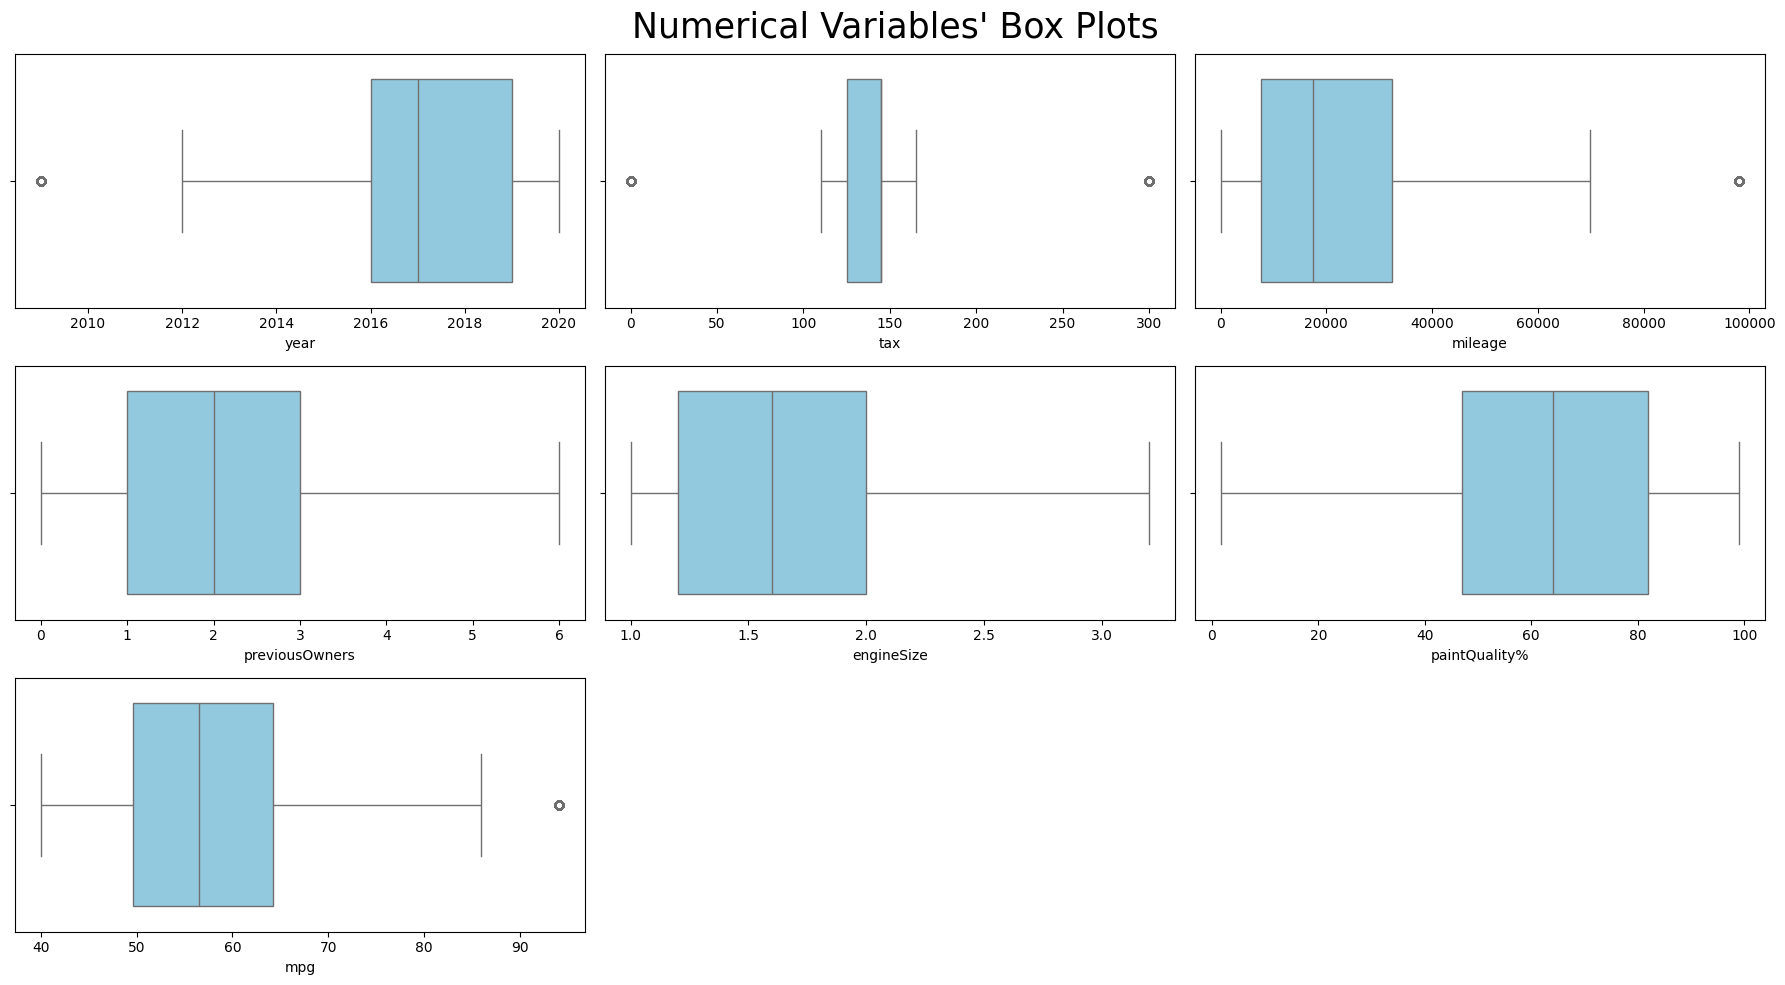

In [58]:
import seaborn as sns

numeric_features = ['year', 'tax', 'mileage', 'previousOwners', 'engineSize', 'paintQuality%', 'mpg']

fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize = (18,10))


for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=X[feat], ax=ax, color='skyblue')

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')

plt.suptitle("Numerical Variables' Box Plots", fontsize=25)

plt.tight_layout()
plt.show()

In [59]:
# Missing_Value_Treatment
missing = Missing_Value_Treatment()
X = missing.fit_transform(X)
print("Missing Treatment works")

Missing Treatment works


In [60]:
# Typecasting
type = Typecasting()
X = type.fit_transform(X)
print("Typecasting works")

Typecasting works


In [61]:
# Test Feature_Engineering
feature_eng = Feature_Engineering()
X = feature_eng.fit_transform(X,y)
print("Feature Eng works")

Feature Eng works


In [62]:
X.isna().sum()

year                    0
mileage                 0
tax                     0
mpg                     0
engineSize              0
paintQuality%           0
previousOwners          0
hasDamage               0
Brand_cleaned           0
transmission_cleaned    0
fuelType_cleaned        0
model_cleaned           0
carAge                  0
AvgUsage                0
carSegment              0
dtype: int64

In [63]:
# Encoder
code = Encoder()
X = code.fit_transform(X,y)
print("Encoder works")

Encoder works


In [64]:
# Scaler
scaler = Scaler()
X = scaler.fit_transform(X,y)
print("Scaler works")

Scaler works


In [65]:
X.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'carAge', 'AvgUsage', 'carSegment',
       'model_cleaned_encoded', 'Brand_cleaned_encoded',
       'fuelType_cleaned_DIESEL', 'fuelType_cleaned_ELECTRIC',
       'fuelType_cleaned_HYBRID', 'fuelType_cleaned_OTHER',
       'fuelType_cleaned_PETROL', 'transmission_cleaned_AUTOMATIC',
       'transmission_cleaned_MANUAL', 'transmission_cleaned_OTHER',
       'transmission_cleaned_SEMI-AUTO', 'transmission_cleaned_UNKNOWN'],
      dtype='object')

In [66]:
# Test Categorical_Correction
selection = Feature_Selection()
X = selection.fit_transform(X,y)
print("Feat Selection works")

Feat Selection works


In [67]:
X.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'carAge', 'AvgUsage',
       'carSegment', 'model_cleaned_encoded', 'Brand_cleaned_encoded',
       'fuelType_cleaned_DIESEL', 'fuelType_cleaned_PETROL',
       'transmission_cleaned_MANUAL', 'transmission_cleaned_SEMI-AUTO',
       'fuelType_cleaned_ELECTRIC', 'fuelType_cleaned_OTHER'],
      dtype='object')